# 神奈川県のコロナデータ分析

In [1]:
import datetime as dt
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style(style="darkgrid", rc=None)
sns.set(font_scale = 1.2)
plt.figure(figsize=(12, 6))

import japanize_matplotlib

<Figure size 864x432 with 0 Axes>

In [3]:
import sys
sys.path.append('../')
%cd '../'

import src.tool as tool

%reload_ext autoreload
%autoreload 2

/home/tsu-nera/repo/hack-for-corona


In [4]:
patients = tool.read_patients()

In [5]:
patients.tail(5)

,感染例番号,情報公開日,発病確認日,居住地,年代,性別,職業,備考,情報元
135,NaN,2020-03-31,NaN,神奈川県平塚保健福祉事務所管内,60代,男性,NaN,NaN,NaN
136,NaN,2020-03-31,NaN,神奈川県平塚保健福祉事務所管内,50代,女性,NaN,NaN,NaN
137,NaN,2020-03-31,NaN,神奈川県川崎市,50代,男性,NaN,NaN,NaN
138,NaN,2020-03-31,NaN,神奈川県川崎市,40代,男性,NaN,NaN,NaN
139,NaN,2020-03-31,NaN,神奈川県川崎市,10代,女性,NaN,NaN,NaN


In [6]:
patients = patients.drop(["感染例番号","備考", "情報元"], axis=1)
patients["id"] = patients.index

In [7]:
n = len(patients)
latest_date = patients.iloc[-1]["情報公開日"]
print("神奈川県の感染者 {}人({}現在)".format(n, latest_date))

神奈川県の感染者 140人(2020-03-31現在)


## 感染者数の時系列推移

In [8]:
time_df = patients

In [9]:
time_df.index = pd.to_datetime(patients["情報公開日"])
time_df["date"] = pd.to_datetime(patients["情報公開日"])
time_df["year"] = time_df.index.year
time_df["month"] = time_df.index.month
time_df["week_of_month"] = time_df.index.week
time_df["year_and_wom"] = time_df.index.strftime('%Y-W%W')
time_df["year_and_month"] = time_df.index.strftime('%Y-%m')

time_df = patients.sort_values("date")

In [10]:
start_date=time_df.iloc[0]["date"]
end_date=time_df.iloc[-1]["date"]

In [11]:
date=start_date
dates=[]
while date <= end_date:
    dates.append(date)
    date += dt.timedelta(days=1)
    
dates2=[]
i=0
date=start_date
while date <= end_date:
    if i%7 == 0:
        dates2.append(date.strftime('%Y-%m-%d'))
    else:
        dates2.append(None)
    i+=1
    date += dt.timedelta(days=1)

### 日別

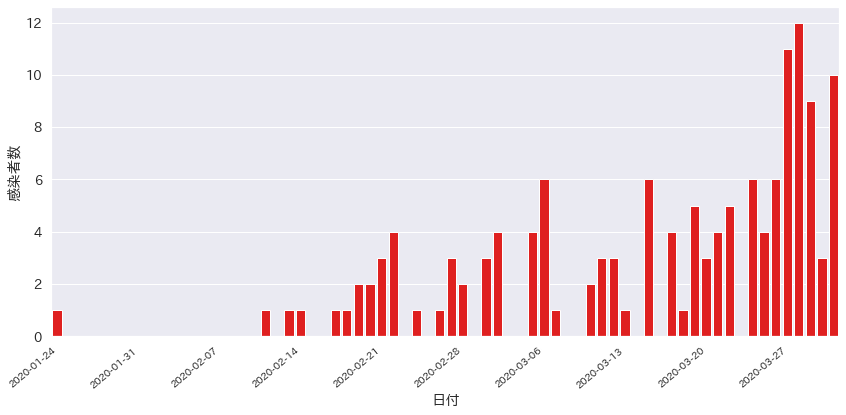

In [12]:
fig,ax = plt.subplots(figsize=(12, 6))

ax = sns.countplot(x="date", data=time_df, color="red", order=dates, ax=ax)

ax.set_xticklabels(dates2, rotation=40, ha="right", fontsize=10)
ax.set_xlabel('日付')
ax.set_ylabel('感染者数')

plt.tight_layout()
plt.show()

### 累計

In [13]:
df_days = time_df.groupby("date").count()

In [14]:
df_days["date"] = pd.to_datetime(df_days.index)
df_days["count"] = df_days["id"].cumsum()

Text(0, 0.5, '感染者数')

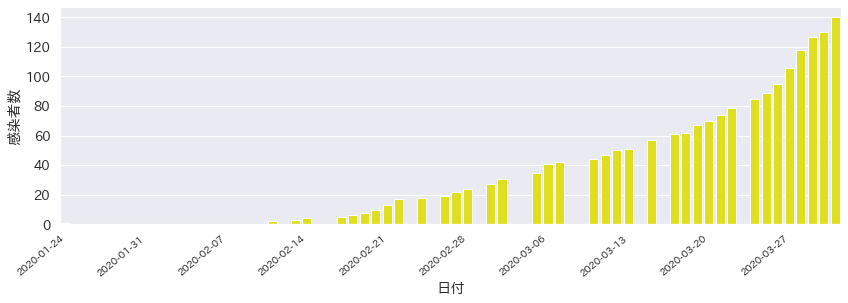

In [15]:
fig,ax = plt.subplots(figsize=(14, 4))

ax = sns.barplot(x="date", y="count", data=df_days, ax=ax, color="yellow", order=dates)

ax.set_xticklabels(dates2, rotation=40, ha="right", fontsize=10)
ax.set_xlabel('日付')
ax.set_ylabel('感染者数')

### 週別

In [16]:
groupby = time_df.groupby('year_and_wom')

In [17]:
df_by_week = pd.DataFrame()
df_by_week["感染者数"] = groupby["id"].count()
df_by_week["累積感染者数"] = groupby["id"].count().cumsum()
df_by_week["週番号"] = df_by_week.index

Text(0, 0.5, '感染者数')

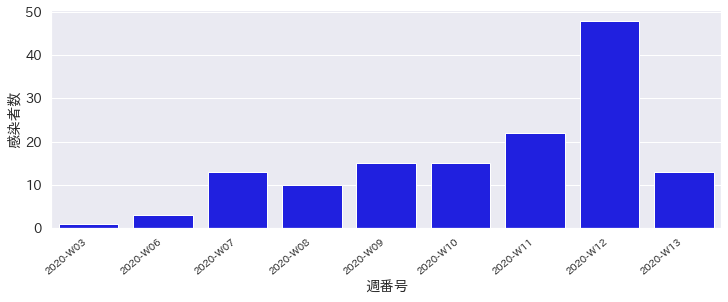

In [18]:
fig,ax = plt.subplots(figsize=(12, 4))

ax = sns.barplot(x="週番号", y="感染者数", data=df_by_week, ax=ax, color="blue")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10)
ax.set_xlabel('週番号')
ax.set_ylabel('感染者数')

In [19]:
df_by_week.drop(["週番号"], axis=1, inplace=True)
df_by_week.index.name = '週別'
df_by_week

,感染者数,累積感染者数
週別,,
2020-W03,1,1
2020-W06,3,4
2020-W07,13,17
2020-W08,10,27
2020-W09,15,42
2020-W10,15,57
2020-W11,22,79
2020-W12,48,127
2020-W13,13,140


### 月別

In [20]:
groupby = time_df.groupby('year_and_month')

In [21]:
df_by_month = pd.DataFrame()
df_by_month["感染者数"] = groupby["id"].count()
df_by_month["累積感染者数"] = groupby["id"].count().cumsum()
df_by_month["年月"] = df_by_month.index

Text(0, 0.5, '感染者数')

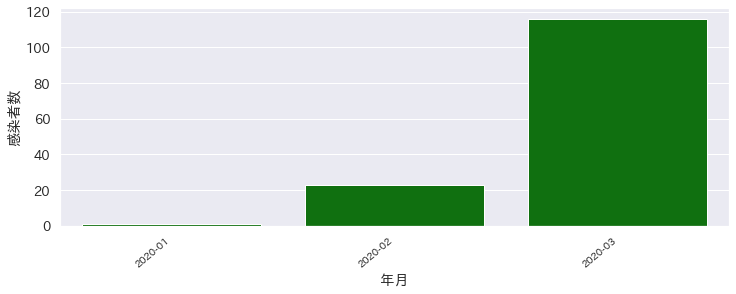

In [22]:
fig,ax = plt.subplots(figsize=(12, 4))

ax = sns.barplot(x="年月", y="感染者数", data=df_by_month, ax=ax, color="green")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10)
ax.set_xlabel('年月')
ax.set_ylabel('感染者数')

In [23]:
df_by_month.drop(["年月"], axis=1, inplace=True)
df_by_month.index.name = '月別'
df_by_month

,感染者数,累積感染者数
月別,,
2020-01,1,1
2020-02,23,24
2020-03,116,140


## 属性別感染者数

### 地域別

In [24]:
area = patients.copy()
area["居住地"] = area["居住地"].apply(tool.cut_ku)
area_df = area.groupby("居住地").count().sort_values("id", ascending=False)["id"].to_frame()
area_df.rename(columns={"id": "感染者数"}, inplace=True)

In [25]:
area_df

,感染者数
居住地,
神奈川県相模原市,29
神奈川県横浜市,27
神奈川県川崎市,21
神奈川県平塚保健福祉事務所管内,15
神奈川県厚木保健福祉事務所管内,12
神奈川県鎌倉保健福祉事務所管内,10
神奈川県藤沢市,8
神奈川県横須賀市,7
神奈川県,4


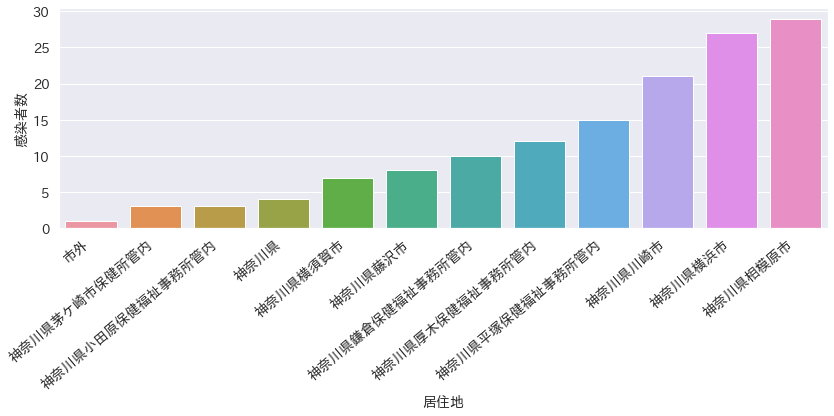

In [26]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="居住地", data=area, order=area['居住地'].value_counts(ascending=True).index)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=14)
ax.set_xlabel('居住地',fontsize=14)
ax.set_ylabel('感染者数',fontsize=14)

plt.tight_layout()
plt.show()

### 年代別

In [27]:
age = patients.copy()
age_df = age.groupby("年代").count()["id"].to_frame()
age_df.rename(columns={"id": "感染者数"}, inplace=True)

In [28]:
age_df

,感染者数
年代,
10代,2
20代,25
30代,20
40代,21
50代,21
60代,19
70代,16
80代,8
90代,3


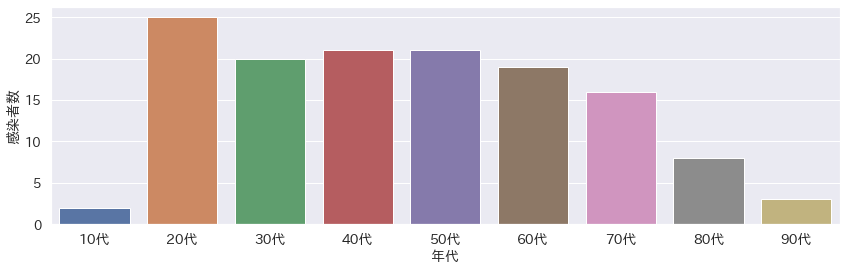

In [29]:
plt.figure(figsize=(12, 4))
ax = sns.countplot(x="年代", data=age, order=["10代", "20代", "30代", "40代", "50代", "60代", "70代", "80代", "90代"])

ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

ax.set_xlabel('年代',fontsize=14)
ax.set_ylabel('感染者数',fontsize=14)

plt.tight_layout()
plt.show()

### 男女別

In [30]:
sex_df = patients.copy()
sex_df = sex_df.groupby("性別").count()["id"].to_frame()
sex_df.rename(columns={"id": "感染者数"}, inplace=True)

In [31]:
sex_df

,感染者数
性別,
女性,53
男性,83


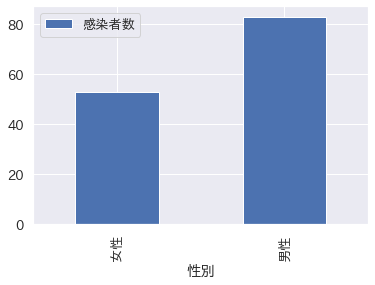

In [32]:
sex_df.plot.bar()

## 職種別

In [33]:
work_df = patients.copy()

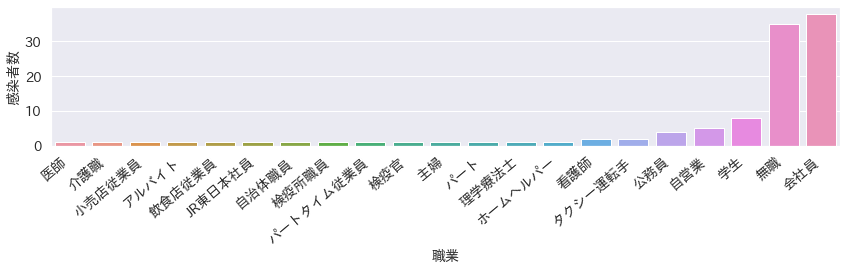

In [34]:
plt.figure(figsize=(12, 4))
ax = sns.countplot(x="職業", data=patients, order=patients['職業'].value_counts(ascending=True).index)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=14)

ax.set_xlabel('職業',fontsize=14)
ax.set_ylabel('感染者数',fontsize=14)

plt.tight_layout()
plt.show()

In [35]:
work_df = work_df.groupby("職業").count()["id"].to_frame()
work_df.rename(columns={"id": "感染者数"}, inplace=True)

In [36]:
work_df

,感染者数
職業,
JR東日本社員,1
アルバイト,1
タクシー運転手,2
パート,1
パートタイム従業員,1
ホームヘルパー,1
主婦,1
介護職,1
会社員,38


In [37]:
##

## 川崎市

In [38]:
kawasaki_df = patients.query ("居住地.str.contains ('川崎市')",engine="python")

In [39]:
area = kawasaki_df.copy()
area["居住地"] = area["居住地"]
area_df = area.groupby("居住地").count().sort_values("id", ascending=False)["id"].to_frame()
area_df.rename(columns={"id": "感染者数"}, inplace=True)

In [40]:
area_df

,感染者数
居住地,
神奈川県川崎市,5
神奈川県川崎市中原区,4
神奈川県川崎市宮前区,3
神奈川県川崎市麻生区,3
神奈川県川崎市川崎区,2
神奈川県川崎市高津区,2
神奈川県川崎市多摩区,1
神奈川県川崎市幸区,1


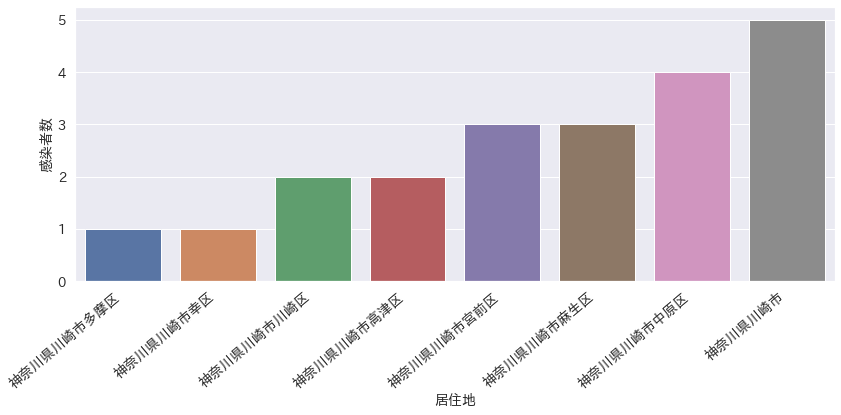

In [41]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="居住地", data=area, order=area['居住地'].value_counts(ascending=True).index)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=14)
ax.set_xlabel('居住地',fontsize=14)
ax.set_ylabel('感染者数',fontsize=14)

plt.tight_layout()
plt.show()